# Урок 9. Языковое моделирование

Разобраться с моделькой генерации текста, собрать самим или взять датасет с вебинара и обучить генератор

In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import matplotlib.pyplot as plt

2023-10-15 20:27:49.454632: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 20:27:50.235814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
text = open('evgenyi_onegin.txt', 'rb').read().decode(encoding='utf-8')
vocab = sorted(set(text))
print(f'Уникальных симоволов: {len(vocab)}')
text += text # его не хватает для обучения
print(f'Всего симоволов: {len(text)}')

Уникальных симоволов: 131
Всего симоволов: 573968


In [3]:
# индексируем символы
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [4]:
# Установим максимальную длину предложения (в символах)
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

''.join([idx2char[i.numpy()] for i in char_dataset.take(10)])

2023-10-15 20:27:52.654724: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15406 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:a1:00.0, compute capability: 6.0


'Александр '

In [5]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'Александр Сергеевич Пушкин\n\n                                Евгений Онегин\n                          '
'      Роман в стихах\n\n                        Не мысля гордый свет забавить,\n                        '
'Вниманье дружбы возлюбя,\n                        Хотел бы я тебе представить\n                        '
'Залог достойнее тебя,\n                        Достойнее души прекрасной,\n                        Свят'
'ой исполненной мечты,\n                        Поэзии живой и ясной,\n                        Высоких д'


In [6]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

# Разделим батчи на признаки и целевую переменную (последня буква) и применим ко всему датасету
dataset = sequences.map(split_input_target)

In [7]:
for input_example, target_example in  dataset.take(1):
    print('Входные данные: ', repr(''.join(idx2char[input_example.numpy()])))
    print('Предсказания: ', repr(''.join(idx2char[target_example.numpy()])))

Входные данные:  'Александр Сергеевич Пушкин\n\n                                Евгений Онегин\n                         '
Предсказания:  'лександр Сергеевич Пушкин\n\n                                Евгений Онегин\n                          '


# LSTM

In [8]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [9]:
# модель из LSTM-блоков
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
                                 
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),

        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),

         tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
                                   
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [10]:
# !rm -rf training_checkpoints_lstm

In [11]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)
# model.summary()

In [12]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(f"batch_size = {example_batch_predictions.shape[0]}")
    print(f"sequence_length = {example_batch_predictions.shape[1]}")
    print(f"vocab_size = {example_batch_predictions.shape[2]}")

2023-10-15 20:27:54.115175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905


batch_size = 64
sequence_length = 100
vocab_size = 131


In [13]:
# функция потерь
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
print(f"batch_size = {example_batch_predictions.shape[0]}")
print(f"sequence_length = {example_batch_predictions.shape[1]}")
print(f"vocab_size = {example_batch_predictions.shape[2]}")
print(f"scalar_loss = {example_batch_loss.numpy().mean()}")

batch_size = 64
sequence_length = 100
vocab_size = 131
scalar_loss = 4.873912334442139


In [14]:
!rm -rf ./training_checkpoints_lstm

In [15]:
model.compile(optimizer='adam', loss=loss, metrics='accuracy')

checkpoint_dir = './training_checkpoints_lstm'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath=checkpoint_prefix,
                            save_freq=1000,
                            save_weights_only=True)

EPOCHS = 30

history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/30


2023-10-15 20:27:58.526315: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff4e81f3a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-15 20:27:58.526374: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2023-10-15 20:27:58.530805: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-15 20:27:58.659394: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 [==============================] - 25s 237ms/step - loss: 2.2055 - accuracy: 0.5541
Epoch 2/30
88/88 [==============================] - 20s 217ms/step - loss: 1.7251 - accuracy: 0.5679
Epoch 3/30
88/88 [==============================] - 20s 215ms/step - loss: 1.5412 - accuracy: 0.5860
Epoch 4/30
88/88 [==============================] - 20s 216ms/step - loss: 1.4454 - accuracy: 0.5990
Epoch 5/30
88/88 [==============================] - 21s 227ms/step - loss: 1.3850 - accuracy: 0.6096
Epoch 6/30
88/88 [==============================] - 22s 239ms/step - loss: 1.3409 - accuracy: 0.6183
Epoch 7/30
88/88 [==============================] - 22s 239ms/step - loss: 1.3156 - accuracy: 0.6235
Epoch 8/30
88/88 [==============================] - 22s 247ms/step - loss: 1.2948 - accuracy: 0.6294
Epoch 9/30
88/88 [==============================] - 22s 246ms/step - loss: 1.2623 - accuracy: 0.6360
Epoch 10/30
88/88 [==============================] - 23s 251ms/step - loss: 1.2435 - accuracy: 0.6433


In [19]:
# Если надо загрузить с чекпойнта
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
# model.summary()

In [ ]:
# предсказания текста
def generate_text(model, start_string):

    num_generate = 1000

    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []

    temperature = 0.5 # один из главных параметров, влияющих на смысл

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))


In [21]:
# Предсказываем текст по первой строке
pred = generate_text(model, start_string=u"Мой дядя самых")
len(pred)
print(pred)

Мой дядя самых застроет;
                        Давно ль он в рад они вас он,
                        О коньком обедов, боже!
                                                                                                                                                                                                                                                                                                        XXVI

                        Что ж наши светланая сень.
                        Он в сердце грустной, как суровые,
                        Веселый загывал мой,
                                                                                                                                                                                                                                                                                                                                                                                                                                

## GRU

In [25]:
# со слоями GRU
def build_model_gru(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim),
                                 
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform'),

        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform'),

         tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform'),
                                   
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [26]:
model_gru = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [27]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model_gru(input_example_batch)
    print(f"batch_size = {example_batch_predictions.shape[0]}")
    print(f"sequence_length = {example_batch_predictions.shape[1]}")
    print(f"vocab_size = {example_batch_predictions.shape[2]}")

batch_size = 64
sequence_length = 100
vocab_size = 131


In [28]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (64, None, 256)           33536     
                                                                 
 lstm_8 (LSTM)               (64, None, 1024)          5246976   
                                                                 
 lstm_9 (LSTM)               (64, None, 1024)          8392704   
                                                                 
 lstm_10 (LSTM)              (64, None, 1024)          8392704   
                                                                 
 lstm_11 (LSTM)              (64, None, 1024)          8392704   
                                                                 
 dense_2 (Dense)             (64, None, 131)           134275    
                                                                 
Total params: 30592899 (116.70 MB)
Trainable params: 3

In [29]:
# sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
# sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

# print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
# print()
# print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

In [30]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
print(f"batch_size = {example_batch_predictions.shape[0]}")
print(f"sequence_length = {example_batch_predictions.shape[1]}")
print(f"vocab_size = {example_batch_predictions.shape[2]}")
print(f"scalar_loss = {example_batch_loss.numpy().mean()}")

batch_size = 64
sequence_length = 100
vocab_size = 131
scalar_loss = 4.87722635269165


In [31]:
model_gru.compile(optimizer='adam', loss=loss, metrics='accuracy')

In [32]:
!rm -rf ./training_checkpoints_gru

In [33]:
checkpoint_dir = './training_checkpoints_gru'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath=checkpoint_prefix,
                            save_freq=1000,
                            save_weights_only=True)

In [34]:
EPOCHS = 30

In [35]:
history = model_gru.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/30
88/88 [==============================] - 23s 223ms/step - loss: 2.2545 - accuracy: 0.5541
Epoch 2/30
88/88 [==============================] - 19s 215ms/step - loss: 1.6985 - accuracy: 0.5728
Epoch 3/30
88/88 [==============================] - 20s 216ms/step - loss: 1.5064 - accuracy: 0.5941
Epoch 4/30
88/88 [==============================] - 20s 216ms/step - loss: 1.4092 - accuracy: 0.6059
Epoch 5/30
88/88 [==============================] - 20s 222ms/step - loss: 1.3534 - accuracy: 0.6144
Epoch 6/30
88/88 [==============================] - 21s 234ms/step - loss: 1.3228 - accuracy: 0.6212
Epoch 7/30
88/88 [==============================] - 22s 242ms/step - loss: 1.2933 - accuracy: 0.6280
Epoch 8/30
88/88 [==============================] - 22s 239ms/step - loss: 1.2708 - accuracy: 0.6334
Epoch 9/30
88/88 [==============================] - 22s 244ms/step - loss: 1.2490 - accuracy: 0.6400
Epoch 10/30
88/88 [==============================] - 23s 252ms/step - loss: 1.2162 - accura

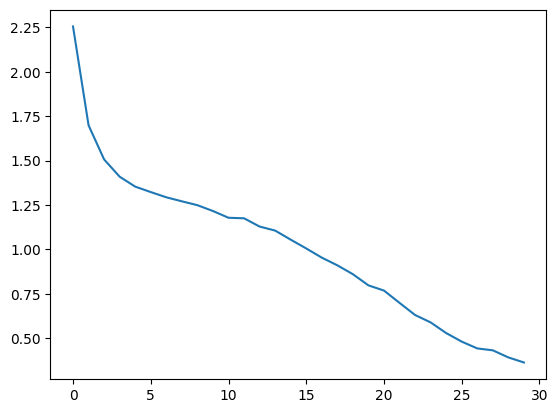

In [36]:
plt.plot(history.history['loss'])
plt.show()

In [37]:
# model_gru = build_model_gru(vocab_size, embedding_dim, rnn_units, batch_size=1)
# model_gru.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
# model_gru.build(tf.TensorShape([1, None]))

In [38]:
# model_gru.summary()

In [41]:
def generate_text(model, start_string):

    num_generate = 1000

    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []

    temperature = 0.5 # один из главных параметров, влияющих на смысл

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [42]:
# Предсказываем текст по первой строке
pred = generate_text(model, start_string=u"Мой дядя самых")
len(pred)
print(pred)

Мой дядя самых снов.

                                           VI

                        И скоро в ней избрандараскает кум его крави
                        И в молчалива, славы небес,
                        И долго пределает не все,
                        В молчалив, и стеклянных сладкой,
                                                                                                                                                                                                                                                                                                                 XXXII

                        Онегин, все выше нет она
                                                                        Все только в своих селенеют,
                        С коня всевился ль для волены.
                        И все были предо меня...
                                                                                                                                         